# C S 329E HW 12

# Association Analysis - Frequent Itemsets and Rule Generation

## Jeremy Ulfohn, Pair 14

Association analysis uses machine learning algorithms to extract hidden relationships from large datasets. In this assignment we'll be using one of the most commonly used algorithms for association rule mining - the Apriori algorithm.

`scikit-learn` does not provide any functionality for association rule mining so for this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. There are several ways of doing this; see the setup guide  [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - Date: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - Time: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - Transaction: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - Item: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [1]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# extra (unneeded and unused)
from sklearn.preprocessing import StandardScaler

## Q1 - Data Analysis
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset 
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

In [23]:
df_breadbasket = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/68177eb3714439d3677d1d59f0b447b2/raw/a20703690503fae59dde42d0217484c00a7fd8c8/BreadBasket.csv')

Text(0, 0.5, 'Count')

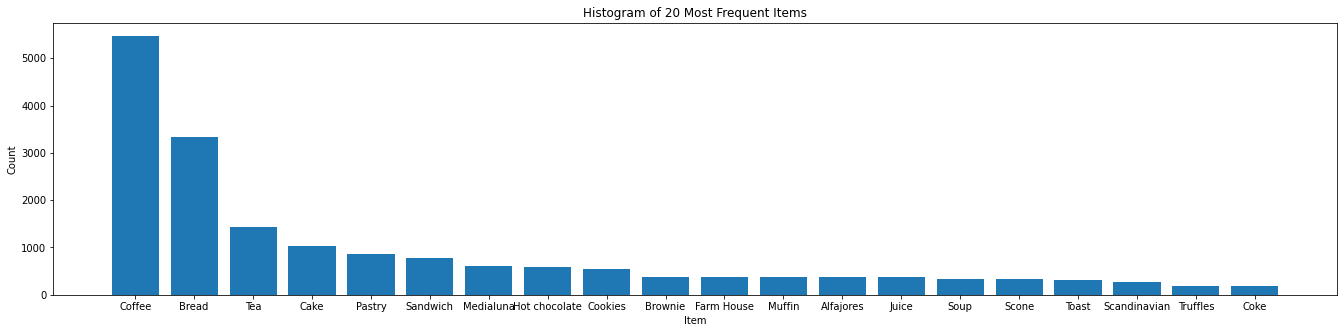

In [24]:
# remove instances of item == 'NONE'
df_breadbasket = df_breadbasket[df_breadbasket['Item'] != 'NONE']

dict_valcounts = dict(df_breadbasket['Item'].value_counts()) # use value_counts()
# sort dict by value, then select only top 20 most frequent
top20 = sorted(dict_valcounts.items(), key=lambda item: item[1], reverse=True)
names, values = [], []
for tup in top20:
    if tup[0] != "NONE": # redundant w mod
        names.append(tup[0])
        values.append(tup[1])
    if len(names) == 20:
        break
# create and fill plt
fig, ax = plt.subplots(figsize=(23,5), sharey=True)
ax.bar(names, values)
plt.title("Histogram of 20 Most Frequent Items")
plt.xlabel("Item")
plt.ylabel("Count")

In [25]:
# calculate the number of unique items
# answer: 94 -- correct
print(len(dict_valcounts), "unique items in the dataset, excluding 'NONE'")


94 unique items in the dataset, excluding 'NONE'


In [26]:
# calculate the number of transactions
# filter out non-uniques
# answer: 9465 -- correct
len_transactions = len(df_breadbasket['Transaction'].unique())
print("There are", len_transactions, "transactions in the dataset")

There are 9465 transactions in the dataset


## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [6]:
# groupby: turn all items from same transaction into a Series
# Series of tuples with (trans_number, [item**])
# groupby Transaction, thence select Item column
grouped_s = pd.Series(df_breadbasket.groupby(by=['Transaction'])['Item'])
# we just want the values, or grouped_s.items[1], of the Series

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1231: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  v = np.array(v, copy=False)
/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  subarr = np.array(values, dtype=dtype, copy=copy)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecat

In [7]:
# create "dataset", an array of lists (or sets) of items in each transaction
dataset = []
for ind, val in grouped_s.items():
    dataset.append(list(val[1]))

In [17]:
# create one-hot enoding using TransactionEncoder() from mlxtend library
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
# dataframe version
df = pd.DataFrame(te_ary, columns=te.columns_) # columns_ underscore refers to the fact that it's an attribute

# look at first 4 in T.E. array
first4 = te_ary[:4]
te.inverse_transform(first4) # TE.inverse_transform() coverts array back from one-hot encoding


[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]

## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [9]:
msupp = 20/len(df.index) # define minimum support fraction (constant) <==> minsupp_n = 20

# return items and itemsets with at LEAST this minsup (>= 100 support)
frequent_itemsets = apriori(df, min_support=msupp, use_colnames=True)

In [10]:
# show last 15 frequent item sets with item names (not indices)
# accomplish this with use_colnames native parameter
frequent_itemsets.iloc[-15:] # negative starts from -1 ++ (-1)

,support,itemsets
229,0.003909,"(Cookies, Coffee, Tea)"
230,0.003064,"(Coffee, Medialuna, Hot chocolate)"
231,0.003803,"(Pastry, Coffee, Hot chocolate)"
232,0.002536,"(Coffee, Sandwich, Hot chocolate)"
233,0.002747,"(Coffee, Sandwich, Juice)"
234,0.004860,"(Pastry, Coffee, Medialuna)"
235,0.003698,"(Coffee, Medialuna, Tea)"
236,0.002853,"(Muffin, Coffee, Tea)"
237,0.004649,"(Pastry, Coffee, Tea)"
238,0.003592,"(Coffee, Sandwich, Soup)"


In [18]:
# check length of frequent_itemsets df
len(frequent_itemsets)

244

## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [11]:
# confidence(A --> C) := support(A --> C) / support(A)
# count === 43 ( '===' --> ended up equalling)
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
3,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
4,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
6,(Frittata),(Coffee),0.008558,0.478394,0.004543,0.530864,1.109680,0.000449,1.111844
7,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553
9,(Jammie Dodgers),(Coffee),0.013207,0.478394,0.006656,0.504000,1.053525,0.000338,1.051625


➡️ _The association rules for bakery items with confidence level of 50% or above all have one thing in common: the consequent in the rule is ***coffee***, be the antecedent(s) what they may. To wit, the purchase of various items or sets of items may be used to predict an accompanying purchase of coffee._ ⬅️


### Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [21]:
# lift > 3
association_rules(frequent_itemsets, metric="lift", min_threshold=3.0)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Sandwich),(Coke),0.071844,0.019440,0.005177,0.072059,3.706722,0.003780,1.056705
1,(Coke),(Sandwich),0.019440,0.071844,0.005177,0.266304,3.706722,0.003780,1.265043
2,(Jam),(Fudge),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
3,(Fudge),(Jam),0.015003,0.015003,0.002536,0.169014,11.265622,0.002311,1.185336
4,(Juice),(Jammie Dodgers),0.038563,0.013207,0.002113,0.054795,4.149041,0.001604,1.043999
5,(Jammie Dodgers),(Juice),0.013207,0.038563,0.002113,0.160000,4.149041,0.001604,1.144568
6,(Spanish Brunch),(Juice),0.018172,0.038563,0.002747,0.151163,3.919879,0.002046,1.132652
7,(Juice),(Spanish Brunch),0.038563,0.018172,0.002747,0.071233,3.919879,0.002046,1.057130
8,(Sandwich),(Mineral water),0.071844,0.014157,0.003275,0.045588,3.220094,0.002258,1.032932
9,(Mineral water),(Sandwich),0.014157,0.071844,0.003275,0.231343,3.220094,0.002258,1.207504


In [13]:
# leverage > 0.004
association_rules(frequent_itemsets, metric="leverage", min_threshold=0.004)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee),(Cake),0.478394,0.103856,0.054728,0.114399,1.101515,0.005044,1.011905
1,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
2,(Cake),(Hot chocolate),0.103856,0.058320,0.011410,0.109868,1.883874,0.005354,1.057910
3,(Hot chocolate),(Cake),0.058320,0.103856,0.011410,0.195652,1.883874,0.005354,1.114125
4,(Cake),(Tea),0.103856,0.142631,0.023772,0.228891,1.604781,0.008959,1.111865
5,(Tea),(Cake),0.142631,0.103856,0.023772,0.166667,1.604781,0.008959,1.075372
6,(Coffee),(Medialuna),0.478394,0.061807,0.035182,0.073542,1.189878,0.005614,1.012667
7,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
8,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682
9,(Coffee),(Pastry),0.478394,0.086107,0.047544,0.099382,1.154168,0.006351,1.014740


In [14]:
# conviction > 1.2
# conviction of X --> Y compares P_predicted and P_actual of X appearing WITHOUT y in the dataset
association_rules(frequent_itemsets, metric="conviction", min_threshold=1.2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
1,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
2,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
3,(Keeping It Local),(Coffee),0.006656,0.478394,0.005388,0.809524,1.692169,0.002204,2.738431
4,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871
5,(Salad),(Coffee),0.010460,0.478394,0.006550,0.626263,1.309094,0.001547,1.395648
6,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235
7,(Tartine),(Coffee),0.004860,0.478394,0.003064,0.630435,1.317815,0.000739,1.411404
8,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582
9,(Vegan mincepie),(Coffee),0.005494,0.478394,0.003170,0.576923,1.205958,0.000541,1.232887


## Q6 - Find the Maximal Itemsets
Using the frequent itemsets and support counts in Q3, find and display all the maximal frequent itemsets along with their support fraction. Also print a count of how many maximal frequent itemsets you have found. (MLxtend does not provide a function to do this - you will need to write it yourself.)

In [30]:
# write a function to find and display all the maximal frequent itemsets...
# ... along with their support fraction
# def'n: maximal frequent itemset :== itemset for which none of its...
# ... immediate SUPERsets are frequent

frequent = frequent_itemsets # rename for compatibility

# Task: Find max frequent itemset using extant frequent itemsets
su = frequent.support.unique()#all unique support count

#Dictionay storing itemset with  support count <= key
fredic = {}
for i in range(len(su)):
    inset = list(frequent.loc[frequent.support<=su[i]]['itemsets'])
    fredic[su[i]] = inset

# now: find Max frequent itemsets
ml = []
for index, row in frequent.iterrows():
    isclose = True
    # cl = closed
    cli = row['itemsets']
    cls = row['support']
    checkset = fredic[cls]
    for i in checkset:
        if (cli!=i):
            if(frozenset.issubset(cli,i)):
                isclose = False
                break
    
    if(isclose):
        # append tuple of the (maximal frozenset, ms_support)
        ml.append((row['itemsets'], int(row['support']*len(df.index))))


In [31]:
# length of ml (maximal frequent itemsets) list == 139
d_ml = {}
for tup in ml:
    d_ml[tup[0]] = tup[1]
print("Dictionary of Maximal Frequent Itemsets and their Support Counts: \n")
d_ml


Dictionary of Maximal Frequent Itemsets and their Support Counts: 



{frozenset({'Afternoon with the baker'}): 43,
 frozenset({'Eggs'}): 28,
 frozenset({'Focaccia'}): 54,
 frozenset({'Granola'}): 28,
 frozenset({'Tshirt'}): 21,
 frozenset({'Alfajores', 'Brownie'}): 27,
 frozenset({'Alfajores', 'Cookies'}): 23,
 frozenset({'Alfajores', 'Hot chocolate'}): 34,
 frozenset({'Alfajores', 'Juice'}): 29,
 frozenset({'Alfajores', 'Medialuna'}): 30,
 frozenset({'Alfajores', 'Pastry'}): 31,
 frozenset({'Alfajores', 'Sandwich'}): 25,
 frozenset({'Art Tray', 'Coffee'}): 26,
 frozenset({'Baguette', 'Bread'}): 26,
 frozenset({'Baguette', 'Coffee'}): 28,
 frozenset({'Bakewell', 'Coffee'}): 29,
 frozenset({'Bread', 'Chicken Stew'}): 26,
 frozenset({'Bread', 'Farm House'}): 47,
 frozenset({'Bread', 'Frittata'}): 25,
 frozenset({'Bread', 'Fudge'}): 31,
 frozenset({'Bread', 'Hearty & Seasonal'}): 25,
 frozenset({'Bread', 'Jam'}): 48,
 frozenset({'Bread', 'Jammie Dodgers'}): 44,
 frozenset({'Bread', 'Keeping It Local'}): 21,
 frozenset({'Bread', 'Mineral water'}): 30,
 froz

In [32]:
print("Maximal frequent itemsets count:", len(d_ml))

Maximal frequent itemsets count: 139


## Q7 - Create Actionable Buisness Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

➡️ _The vast majority of the maximal frequent itemsets contain coffee, and similarly, coffee, tea, bread, and cake are the items with the top 4 support counts. I would recommend keeping the price of coffee the same, and offering a discounted pastry/dessert item with the purchase of a sandwich or Spanish Brunch (both of which are lunch items). Each of these are pratically guaranteed to lead to the purchase of a beverage, especially coffee, which is by far the most common consequent in the strong rules, by the hyperparameters of conviction and confidence. Plus, full lunch items are typically the most expensive on the menu and not something that coffee shop goers are as likely to order (which is corroborated by their lower support counts than coffee). Taken together, these observations make increasing the purchase dessert and lunch items (and in turn the beverage sales) worthwhile. _ ⬅️